In [1]:
#@title Installs
!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-datasets==4.8 --quiet #8
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install transformers==4.17 --quiet #4.40.2 #4.37.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.63 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 88.1 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.greater(y_pred, self.threshold), tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
        fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
        fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))

        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + K.epsilon())
        recall = self.tp / (self.tp + self.fn + K.epsilon())
        f1_score = 2 * precision * recall / (precision + recall + K.epsilon())
        return f1_score

    def reset_state(self):
        self.tp.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import classification_report


In [5]:
#@title Imports

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
import transformers

from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, TFBertModel
from transformers import logging
logging.set_verbosity_error()

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.isotonic import IsotonicRegression


# Subtask A: Binary Classification

In [6]:
#@title Data Import for Subtask A
data = pd.read_csv('/content/drive/MyDrive/MIDS W266/train.En.csv')
test_data = pd.read_csv('/content/drive/MyDrive/MIDS W266/task_A_En_test.csv')

# train val split
train_texts, val_texts, train_labels, val_labels = train_test_split(data['tweet'].astype(str).tolist(), data['sarcastic'].tolist(), test_size=0.2)
train_texts, val_texts = tf.constant(train_texts, dtype=tf.string), tf.constant(val_texts, dtype=tf.string)

test_texts, test_labels = np.array(test_data['text']).astype(str).tolist(), test_data['sarcastic']
test_texts = tf.constant(test_texts, dtype=tf.string)
test_texts

<tf.Tensor: shape=(1400,), dtype=string, numpy=
array([b"Size on the the Toulouse team, That pack is monstrous. \n\nI can't see a Welsh region ever winning this, Money talks as they say .",
       b'Pinball!',
       b"So the Scottish Government want people to get their booster shots so badly that the website doesn't even work",
       ..., b'Bringing Kanye and drake to a tl near you',
       b'I love it when women are referred to as "girl boss" however men are just the "boss"!',
       b"The fact that people still don't get that you need to distance, wear a mask, and generally pay attention to your hygiene this far into a pandemic gives me great confidence in the future of humanity."],
      dtype=object)>

In [7]:
sum(test_labels) / len(test_labels)

true_labels = np.zeros(1000)
indices = np.random.choice(range(1000), 143, replace=False)
true_labels[indices] = 1

predicted_labels = np.zeros(1000)
random = np.random.choice(range(1000), 500, replace=False)
predicted_labels[random] = 1

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score(true_labels, predicted_labels, average='binary',pos_label=1)}")
print(f"Precision: {precision_score(true_labels, predicted_labels)}")
print(f"Recall: {recall_score(true_labels, predicted_labels)}")

Accuracy: 0.489
F1 Score: 0.2052877138413686
Precision: 0.132
Recall: 0.46153846153846156


In [8]:
#@title Plotting Function

# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        # small adjustment to account for the 2 accuracy measures in the Weighted Averging Model with Attention
        if 'classification_%s' % metric in model_history2.history:
            metric2 = 'classification_%s' % metric
        else:
            metric2 = metric

        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric2])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric2])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            model_metric = [metric, metric2][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[model_metric])
            ax1.plot(model_history.history['val_%s' % model_metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

In [9]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_texts)
val_tokens = tokenizer.tokenize(val_texts)
test_tokens = tokenizer.tokenize(test_texts)

In [10]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

In [11]:
MAX_SEQUENCE_LENGTH = 100

In [12]:
#@title BERT Tokenization of training, val, and test data

train_examples_str = [x.decode('utf-8') for x in train_texts.numpy()]
val_examples_str = [x.decode('utf-8') for x in val_texts.numpy()]
test_examples_str = [x.decode('utf-8') for x in test_texts.numpy()]

# train
bert_train_tokenized = bert_tokenizer(train_examples_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_train_inputs = [bert_train_tokenized.input_ids,
                     bert_train_tokenized.token_type_ids,
                     bert_train_tokenized.attention_mask]
bert_train_labels = np.array(train_labels)

# val
bert_val_tokenized = bert_tokenizer(val_examples_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_val_inputs = [bert_val_tokenized.input_ids,
                     bert_val_tokenized.token_type_ids,
                     bert_val_tokenized.attention_mask]
bert_val_labels = np.array(val_labels)

# test
bert_test_tokenized = bert_tokenizer(test_examples_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_test_inputs = [bert_test_tokenized.input_ids,
                     bert_test_tokenized.token_type_ids,
                     bert_test_tokenized.attention_mask]
bert_test_labels = np.array(test_labels)

In [13]:
def create_bert_cls_model(bert_base_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=0.00005,
                          num_train_layers=2):
    """
    Build a simple classification model with BERT. Use the CLS Token output for classification purposes.
    """

    ### YOUR CODE HERE

    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_base_model.trainable = False
    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_base_model.trainable = True
    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []
        for retrain_layer_number in range(num_train_layers):
            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)
        print('retrain layers: ', retrain_layers)
        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_base_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]  # Extract the [CLS] token embedding

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy'])

    ### END YOUR CODE

    return classification_model

In [15]:
bert_classification_model = create_bert_cls_model(bert_model, num_train_layers=0)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

bert_classification_model_history = bert_classification_model.fit(
    bert_train_inputs,
    bert_train_labels,
    validation_data=(bert_val_inputs, bert_val_labels),
    batch_size=8,
    epochs=5,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/5
347/347 [==============================] - 64s 117ms/step - loss: 0.6057 - accuracy: 0.7210 - val_loss: 0.5689 - val_accuracy: 0.7450 - lr: 5.0000e-05
Epoch 2/5
347/347 [==============================] - 36s 104ms/step - loss: 0.5761 - accuracy: 0.7480 - val_loss: 0.5669 - val_accuracy: 0.7450 - lr: 5.0000e-05
Epoch 3/5
347/347 [==============================] - 36s 104ms/step - loss: 0.5647 - accuracy: 0.7513 - val_loss: 0.5617 - val_accuracy: 0.7450 - lr: 5.0000e-05
Epoch 4/5
347/347 [==============================] - 36s 104ms/step - loss: 0.5632 - accuracy: 0.7505 - val_loss: 0.5598 - val_accuracy: 0.7450 - lr: 5.0000e-05
Epoch 5/5
347/347 [==============================] - 36s 105ms/step - loss: 0.5526 - accuracy: 0.7516 - val_loss: 0.5590 - val_accuracy: 0.7450 - lr: 5.0000e-05


In [62]:
# Obtain predicted probabilities for validation set
valid_predictions_cls = bert_classification_model.predict(bert_val_inputs)
valid_probabilities_cls = valid_predictions_cls.flatten()  # Ensure the shape is correct
valid_labels_cls = bert_val_labels.flatten()

test_predictions_cls = bert_classification_model.predict(bert_test_inputs)
test_probabilities_cls = test_predictions_cls.flatten()  # Ensure the shape is correct
# calibrated_probabilities = iso_reg.transform(test_probabilities)

# Predict classes using calibrated probabilities
predicted_classes_cls = (test_probabilities_cls > np.percentile(test_probabilities_cls, 50))

# Evaluate the model using the calibrated probabilities
print(classification_report(bert_test_labels, predicted_classes_cls))

test_accuracy1 = accuracy_score(bert_test_labels, predicted_classes_cls)
print(f"Test Accuracy: {test_accuracy1}")

f1_sarcastic = f1_score(bert_test_labels,predicted_classes_cls, average = "binary", pos_label = 1)
print(f"F1 Sarcastic score: {f1_sarcastic}")

44/44 [==============================] - 10s 221ms/step
              precision    recall  f1-score   support

           0       0.86      0.50      0.63      1200
           1       0.15      0.51      0.23       200

    accuracy                           0.50      1400
   macro avg       0.50      0.51      0.43      1400
weighted avg       0.76      0.50      0.58      1400

Test Accuracy: 0.5028571428571429
F1 Sarcastic score: 0.22666666666666668


In [16]:
def create_bert_cnn_model(bert_cnn_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          num_filters = [50, 30, 20, 5],
                          kernel_sizes = [2, 3, 4, 5],
                          dropout = 0.3,
                          hidden_size = 100,
                          learning_rate=0.005):
    """
    Build a  classification model with BERT, where you apply CNN layers  to the BERT output
    """

    ### YOUR CODE HERE

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_cnn_model(bert_inputs)
    sequence_output = bert_out[0]  # Full sequence output from BERT

    # Apply CNN layers to the BERT output
    conv_layers = []
    for num_filter, kernel_size in zip(num_filters, kernel_sizes):
        conv = tf.keras.layers.Conv1D(filters=num_filter,
                                      kernel_size=kernel_size,
                                      activation='relu')(sequence_output)
        pool = tf.keras.layers.GlobalMaxPooling1D()(conv)
        conv_layers.append(pool)

    cnn_output = tf.keras.layers.concatenate(conv_layers)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cnn_output)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy'])

    ### END YOUR CODE

    return classification_model

In [17]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(bert_train_labels), y=bert_train_labels)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
# class_weights = {0:1, 1:5}
class_weights

{0: 0.6655470249520153, 1: 2.0101449275362318}

In [18]:
# ### YOUR CODE HERE

bert_model = TFBertModel.from_pretrained('bert-base-cased')
bert_cnn_model1 = create_bert_cnn_model(bert_model,
                                       dropout=0.5,
                                       learning_rate=0.001)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

bert_cnn_history1 = bert_cnn_model1.fit(
    bert_train_inputs,
    bert_train_labels,
    validation_data=(bert_val_inputs, bert_val_labels),
    batch_size=8,
    epochs=10,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

# ### END YOUR CODE

Epoch 1/10


347/347 [==============================] - 135s 242ms/step - loss: 0.8211 - accuracy: 0.4921 - val_loss: 0.5928 - val_accuracy: 0.7450 - lr: 0.0010
Epoch 2/10
347/347 [==============================] - 81s 232ms/step - loss: 0.7581 - accuracy: 0.5022 - val_loss: 0.5731 - val_accuracy: 0.7450 - lr: 0.0010
Epoch 3/10
347/347 [==============================] - 79s 229ms/step - loss: 0.7250 - accuracy: 0.5014 - val_loss: 0.6387 - val_accuracy: 0.7450 - lr: 0.0010
Epoch 4/10
347/347 [==============================] - 80s 229ms/step - loss: 0.7103 - accuracy: 0.5087 - val_loss: 1.3838 - val_accuracy: 0.2550 - lr: 0.0010
Epoch 5/10
347/347 [==============================] - 75s 217ms/step - loss: 0.7033 - accuracy: 0.5025 - val_loss: 1.2266 - val_accuracy: 0.2550 - lr: 2.0000e-04


In [20]:
# Obtain predicted probabilities for validation set
valid_predictions = bert_cnn_model1.predict(bert_val_inputs)
valid_probabilities = valid_predictions.flatten()  # Ensure the shape is correct
valid_labels = bert_val_labels.flatten()

test_predictions = bert_cnn_model1.predict(bert_test_inputs)
test_probabilities = test_predictions.flatten()  # Ensure the shape is correct
# calibrated_probabilities = iso_reg.transform(test_probabilities)

# Predict classes using calibrated probabilities
predicted_classes = (test_probabilities > np.percentile(test_probabilities, 60))

# Evaluate the model using the calibrated probabilities
print(classification_report(bert_test_labels, predicted_classes))

test_accuracy1 = accuracy_score(bert_test_labels, predicted_classes)
print(f"Test Accuracy: {test_accuracy1}")

f1_sarcastic = f1_score(bert_test_labels,predicted_classes, average = "binary", pos_label = 1)
print(f"F1 Sarcastic score: {f1_sarcastic}")

44/44 [==============================] - 12s 262ms/step
              precision    recall  f1-score   support

           0       0.85      0.62      0.72      1200
           1       0.14      0.36      0.20       200

    accuracy                           0.58      1400
   macro avg       0.50      0.49      0.46      1400
weighted avg       0.75      0.58      0.64      1400

Test Accuracy: 0.5821428571428572
F1 Sarcastic score: 0.1997264021887825


## Skip from here

In [21]:
test_predictions_noweights = bert_cnn_model1.predict(bert_test_inputs)
test_predictions_binary_noweights = (test_predictions_noweights> 0.5).astype(int)

# Compute and print classification report
print(classification_report(bert_test_labels, test_predictions_binary_noweights))

# Compute and print accuracy
test_accuracy_noweights = accuracy_score(bert_test_labels, test_predictions_binary_noweights)
print(f"Test Accuracy: {test_accuracy1}")


44/44 [==============================] - 9s 207ms/step
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1200
           1       0.00      0.00      0.00       200

    accuracy                           0.86      1400
   macro avg       0.43      0.50      0.46      1400
weighted avg       0.73      0.86      0.79      1400

Test Accuracy: 0.5821428571428572


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
test_predictions_noweights

array([[0.21192892],
       [0.21192901],
       [0.21192862],
       ...,
       [0.2119285 ],
       [0.21192889],
       [0.21192889]], dtype=float32)

In [23]:
test_predictions1 = bert_cnn_model1.predict(bert_test_inputs)
test_predictions_binary1 = (test_predictions1 > 0.5).astype(int)

# Compute and print classification report
print(classification_report(bert_test_labels, test_predictions_binary1))

# Compute and print accuracy
test_accuracy1 = accuracy_score(bert_test_labels, test_predictions_binary1)
print(f"Test Accuracy: {test_accuracy1}")


44/44 [==============================] - 9s 211ms/step
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1200
           1       0.00      0.00      0.00       200

    accuracy                           0.86      1400
   macro avg       0.43      0.50      0.46      1400
weighted avg       0.73      0.86      0.79      1400

Test Accuracy: 0.8571428571428571


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
test_predictions1

array([[0.21192892],
       [0.21192901],
       [0.21192862],
       ...,
       [0.2119285 ],
       [0.21192889],
       [0.21192889]], dtype=float32)

In [25]:
f1_sarcastic = f1_score(bert_test_labels,test_predictions_binary1, average = "binary", pos_label = 1)
f1_sarcastic

0.0

In [26]:
np.array(pd.DataFrame(test_predictions_binary1)[0])

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
# # ### YOUR CODE HERE

bert_model = TFBertModel.from_pretrained('bert-base-cased')
bert_cnn_model2 = create_bert_cnn_model(bert_model)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

bert_cnn_history = bert_cnn_model2.fit(
    bert_train_inputs,
    bert_train_labels,
    validation_data=(bert_val_inputs, bert_val_labels),
    batch_size=8,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


# # ### END YOUR CODE

Epoch 1/10


347/347 [==============================] - 137s 256ms/step - loss: 0.6048 - accuracy: 0.7278 - val_loss: 1.4369 - val_accuracy: 0.2550 - lr: 0.0050
Epoch 2/10
347/347 [==============================] - 80s 232ms/step - loss: 0.5713 - accuracy: 0.7505 - val_loss: 0.9435 - val_accuracy: 0.7450 - lr: 0.0050
Epoch 3/10
347/347 [==============================] - 80s 230ms/step - loss: 0.5673 - accuracy: 0.7509 - val_loss: 0.7074 - val_accuracy: 0.2550 - lr: 0.0050
Epoch 4/10
347/347 [==============================] - 75s 215ms/step - loss: 0.5678 - accuracy: 0.7513 - val_loss: 0.6598 - val_accuracy: 0.7450 - lr: 0.0050
Epoch 5/10
347/347 [==============================] - 79s 229ms/step - loss: 0.5693 - accuracy: 0.7513 - val_loss: 0.5964 - val_accuracy: 0.7450 - lr: 0.0050
Epoch 6/10
347/347 [==============================] - 80s 229ms/step - loss: 0.5711 - accuracy: 0.7513 - val_loss: 0.5751 - val_accuracy: 0.7450 - lr: 0.0050
Epoch 7/10
347/347 [==============================] - 79s 228m

In [63]:

test_predictions2 = bert_cnn_model2.predict(bert_test_inputs)
test_predictions_binary2 = (test_predictions2 > 0.5).astype(int)

# Compute and print classification report
print(classification_report(bert_test_labels, test_predictions_binary2))

# Compute and print accuracy
test_accuracy2 = accuracy_score(bert_test_labels, test_predictions_binary2)
print(f"Test Accuracy: {test_accuracy2}")

f1_sarcastic = f1_score(bert_test_labels,test_predictions_binary2, average = "binary", pos_label = 1)
print(f"F1 Sarcastic score: {f1_sarcastic}")


44/44 [==============================] - 9s 214ms/step
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1200
           1       0.00      0.00      0.00       200

    accuracy                           0.86      1400
   macro avg       0.43      0.50      0.46      1400
weighted avg       0.73      0.86      0.79      1400

Test Accuracy: 0.8571428571428571
F1 Sarcastic score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
def create_bert_avg_model(bert_a_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=0.00005,
                          num_train_layers=0):
    """
    Build a simple classification model with BERT. Use the average of the BERT output tokens
    """

    ### YOUR CODE HERE

    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_a_model.trainable = False
    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_a_model.trainable = True
    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []
        for retrain_layer_number in range(num_train_layers):
            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)
        print('retrain layers: ', retrain_layers)
        for w in bert_a_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_a_model(bert_inputs)

    sequence_output = bert_out[0]  # Full sequence output
    avg_token_embeddings = tf.math.reduce_mean(sequence_output, axis=1)  # Average across tokens

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(avg_token_embeddings)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy'])

    ### END YOUR CODE

    return classification_model

In [30]:
bert_model = TFBertModel.from_pretrained('bert-base-cased')
bert_avg_model = create_bert_avg_model(bert_model, num_train_layers=12)

bert_avg_model_history = bert_avg_model.fit(
    bert_train_inputs,
    bert_train_labels,
    validation_data=(bert_test_inputs, bert_test_labels),
    batch_size=8,
    epochs=10
)

Epoch 1/10


347/347 [==============================] - 130s 250ms/step - loss: 0.5749 - accuracy: 0.7462 - val_loss: 0.4952 - val_accuracy: 0.8564
Epoch 2/10
347/347 [==============================] - 80s 230ms/step - loss: 0.5103 - accuracy: 0.7650 - val_loss: 0.4794 - val_accuracy: 0.8486
Epoch 3/10
347/347 [==============================] - 79s 228ms/step - loss: 0.3532 - accuracy: 0.8533 - val_loss: 0.4340 - val_accuracy: 0.8207
Epoch 4/10
347/347 [==============================] - 79s 228ms/step - loss: 0.1248 - accuracy: 0.9542 - val_loss: 1.0425 - val_accuracy: 0.7486
Epoch 5/10
347/347 [==============================] - 78s 224ms/step - loss: 0.0683 - accuracy: 0.9762 - val_loss: 0.8392 - val_accuracy: 0.7729
Epoch 6/10
347/347 [==============================] - 79s 228ms/step - loss: 0.0442 - accuracy: 0.9867 - val_loss: 0.9260 - val_accuracy: 0.7500
Epoch 7/10
347/347 [==============================] - 78s 224ms/step - loss: 0.0430 - accuracy: 0.9874 - val_loss: 1.5682 - val_accuracy: 0.

In [64]:
# Obtain predicted probabilities for validation set
valid_predictions_avg = bert_avg_model.predict(bert_val_inputs)
valid_probabilities_avg = valid_predictions_avg.flatten()  # Ensure the shape is correct
valid_labels_avg = bert_val_labels.flatten()

test_predictions_avg = bert_avg_model.predict(bert_test_inputs)
test_probabilities_avg = test_predictions_avg.flatten()  # Ensure the shape is correct
# calibrated_probabilities = iso_reg.transform(test_probabilities)

# Predict classes using calibrated probabilities
predicted_classes_avg = (test_probabilities_avg > np.percentile(test_probabilities_avg, 50))

# Evaluate the model using the calibrated probabilities
print(classification_report(bert_test_labels, predicted_classes_avg))

test_accuracy_avg = accuracy_score(bert_test_labels, predicted_classes_avg)
print(f"Test Accuracy: {test_accuracy_avg}")

f1_sarcastic = f1_score(bert_test_labels,predicted_classes_avg, average = "binary", pos_label = 1)
print(f"F1 Sarcastic score: {f1_sarcastic}")

44/44 [==============================] - 10s 216ms/step
              precision    recall  f1-score   support

           0       0.88      0.52      0.65      1200
           1       0.17      0.59      0.26       200

    accuracy                           0.53      1400
   macro avg       0.53      0.56      0.46      1400
weighted avg       0.78      0.53      0.60      1400

Test Accuracy: 0.5271428571428571
F1 Sarcastic score: 0.2644444444444444


In [31]:
def create_bert_avg2_model(bert_a_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=0.0001,
                          num_train_layers=0,
                          l2_reg=0.01):
    """
    Build a simple classification model with BERT. Use the average of the BERT output tokens
    """

    ### YOUR CODE HERE

    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_a_model.trainable = False
    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_a_model.trainable = True
    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []
        for retrain_layer_number in range(num_train_layers):
            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)
        print('retrain layers: ', retrain_layers)
        for w in bert_a_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_a_model(bert_inputs)

    sequence_output = bert_out[0]  # Full sequence output
    avg_token_embeddings = tf.math.reduce_mean(sequence_output, axis=1)  # Average across tokens

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', kernel_regularizer=l2(l2_reg), name='hidden_layer')(avg_token_embeddings)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    f1_score = F1Score(threshold=0.5)

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy', f1_score])

    ### END YOUR CODE

    return classification_model

In [32]:
bert_model = TFBertModel.from_pretrained('bert-base-cased')
bert_avg2_model = create_bert_avg2_model(bert_model, hidden_size=50, dropout=0.4, num_train_layers=5, l2_reg=0.005)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

bert_avg2_model_history = bert_avg2_model.fit(
    bert_train_inputs,
    bert_train_labels,
    validation_data=(bert_test_inputs, bert_test_labels),
    batch_size=16,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

retrain layers:  ['_11', '_10', '_9', '_8', '_7']
Epoch 1/10


174/174 [==============================] - 76s 300ms/step - loss: 1.2560 - accuracy: 0.5252 - f1_score: 0.3418 - val_loss: 1.4476 - val_accuracy: 0.1664 - val_f1_score: 0.2534 - lr: 1.0000e-04
Epoch 2/10
174/174 [==============================] - 47s 270ms/step - loss: 1.1261 - accuracy: 0.6107 - f1_score: 0.4237 - val_loss: 0.7875 - val_accuracy: 0.8650 - val_f1_score: 0.3923 - lr: 1.0000e-04
Epoch 3/10
174/174 [==============================] - 47s 272ms/step - loss: 1.0193 - accuracy: 0.6738 - f1_score: 0.4754 - val_loss: 2.5283 - val_accuracy: 0.1429 - val_f1_score: 0.2500 - lr: 1.0000e-04
Epoch 4/10
174/174 [==============================] - 47s 269ms/step - loss: 0.9003 - accuracy: 0.7383 - f1_score: 0.5502 - val_loss: 0.8227 - val_accuracy: 0.8500 - val_f1_score: 0.3046 - lr: 1.0000e-04
Epoch 5/10
174/174 [==============================] - 48s 274ms/step - loss: 0.6966 - accuracy: 0.8637 - f1_score: 0.7364 - val_loss: 1.1803 - val_accuracy: 0.7450 - val_f1_score: 0.3659 - lr: 2.

In [65]:
test_predictions = bert_avg2_model.predict(bert_test_inputs)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Compute and print classification report
print(classification_report(bert_test_labels, test_predictions_binary))

# Compute and print accuracy
test_accuracy = accuracy_score(bert_test_labels, test_predictions_binary)
print(f"Test Accuracy: {test_accuracy}")

f1_sarcastic = f1_score(bert_test_labels,test_predictions_binary, average = "binary", pos_label = 1)
print(f"F1 Sarcastic score: {f1_sarcastic}")

44/44 [==============================] - 10s 215ms/step
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1200
           1       0.55      0.30      0.39       200

    accuracy                           0.86      1400
   macro avg       0.72      0.63      0.66      1400
weighted avg       0.84      0.86      0.85      1400

Test Accuracy: 0.865
F1 Sarcastic score: 0.3922829581993569


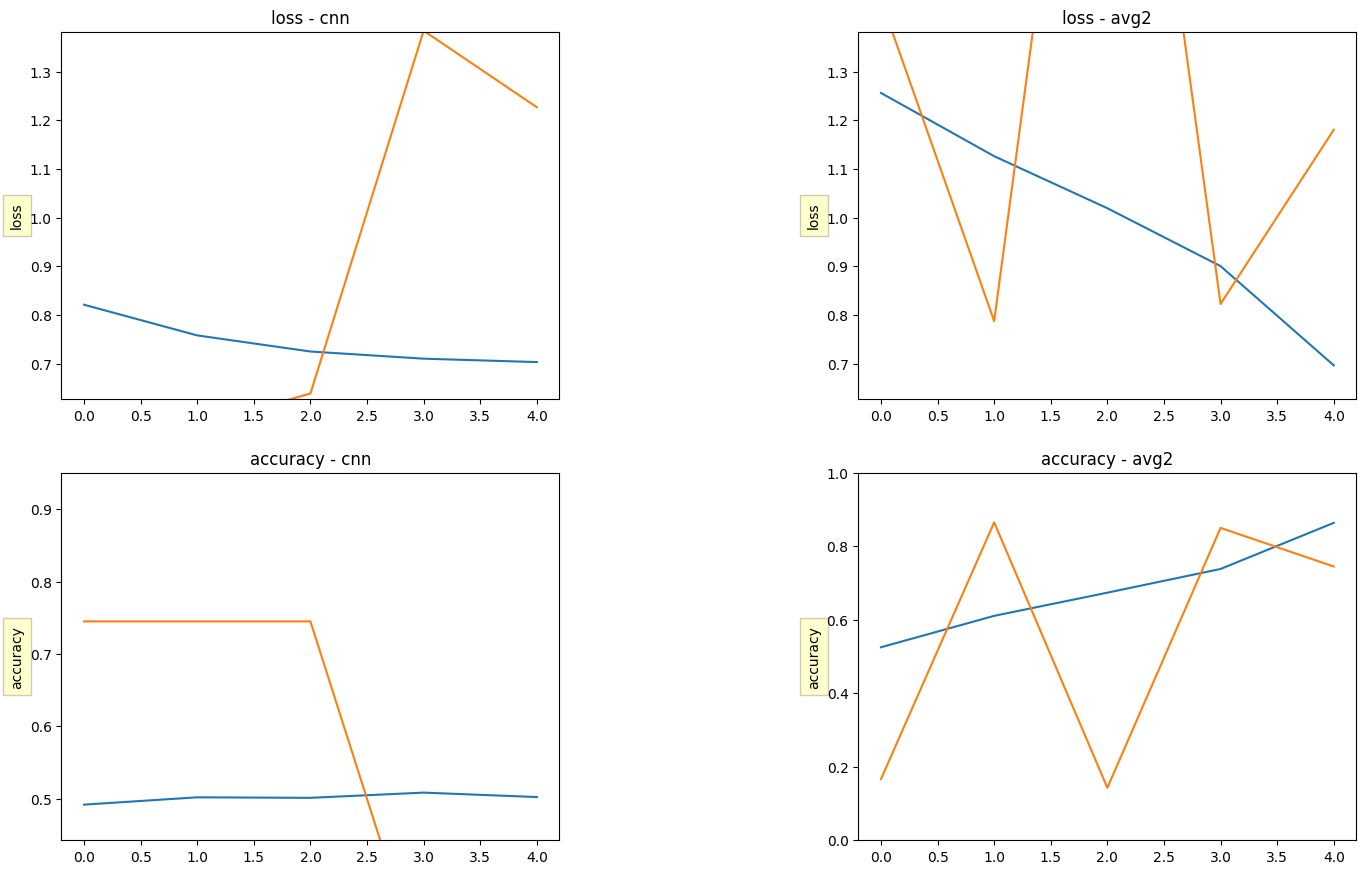

In [34]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          bert_cnn_history1,
          bert_avg2_model_history,
          model_1_name='cnn',
          model_2_name='avg2')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.ylim(0, 1)
plt.show()


## to here

# Subtask B: Multiclass Classification


In [35]:
#@title Data Import for Subtask B
train_df_b = pd.read_csv('/content/drive/MyDrive/MIDS W266/train.En.csv')
train_df_b = train_df_b[~train_df_b['sarcasm'].isna()]
test_df_b = pd.read_csv('/content/drive/MyDrive/MIDS W266/task_B_En_test.csv')
test_df_b = test_df_b[test_df_b['sarcasm']+test_df_b['irony']+test_df_b['satire']+test_df_b['understatement']+test_df_b['overstatement']+test_df_b['rhetorical_question'] != 0]

# Extract texts and labels
train_texts_b = train_df_b['tweet'].tolist()
test_texts_b = test_df_b['text'].tolist()

# Extract labels (assuming binary columns)
# class_columns = ['sarcasm', 'irony', 'satire', 'understatement', 'overstatement', 'rhetorical_question']
class_columns = ['sarcasm', 'irony', 'satire', 'overstatement', 'rhetorical_question']
train_labels_b = train_df_b[class_columns].values
test_labels_b = test_df_b[class_columns].values

# Split training data into training and validation sets
train_texts_b, valid_texts_b, train_labels_b, valid_labels_b = train_test_split(train_texts_b, train_labels_b, test_size=0.2, random_state=42)

# Target names
target_names = class_columns
npvalid_labels = np.asarray(valid_labels_b)

In [36]:
print(sum(test_labels_b) / len(test_labels_b))

true_labels = np.zeros((1000,5))
true_labels[np.random.choice(range(1000), 900, replace=False),0] = 1
true_labels[np.random.choice(range(1000), 100, replace=False),1] = 1
true_labels[np.random.choice(range(1000), 245, replace=False),2] = 1
true_labels[np.random.choice(range(1000), 50, replace=False),3] = 1
true_labels[np.random.choice(range(1000), 55, replace=False),4] = 1

predicted_labels = np.zeros((1000,5))
predicted_labels[np.random.choice(range(1000), 500, replace=False),0] = 1
predicted_labels[np.random.choice(range(1000), 500, replace=False),1] = 1
predicted_labels[np.random.choice(range(1000), 500, replace=False),2] = 1
predicted_labels[np.random.choice(range(1000), 500, replace=False),3] = 1
predicted_labels[np.random.choice(range(1000), 500, replace=False),4] = 1

print(classification_report(true_labels, predicted_labels, target_names=target_names, zero_division=0))

# accuracy = accuracy_score(true_labels, predicted_labels)
# print(f"Accuracy: {accuracy}")
# print(f"F1 Score: {f1_score(true_labels, predicted_labels, average='binary',pos_label=1)}")
# print(f"Precision: {precision_score(true_labels, predicted_labels)}")
# print(f"Recall: {recall_score(true_labels, predicted_labels)}")

[0.9   0.1   0.245 0.05  0.055]
                     precision    recall  f1-score   support

            sarcasm       0.91      0.50      0.65       900
              irony       0.09      0.46      0.15       100
             satire       0.23      0.48      0.31       245
      overstatement       0.05      0.48      0.09        50
rhetorical_question       0.06      0.58      0.12        55

          micro avg       0.27      0.50      0.35      1350
          macro avg       0.27      0.50      0.26      1350
       weighted avg       0.66      0.50      0.51      1350
        samples avg       0.26      0.47      0.31      1350



## 5 Categories

In [37]:
#make it easier to use a variety of BERT subword models
model_checkpoint = 'bert-base-cased'

bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)
max_length = 200


In [38]:
# tokenize the dataset, truncate at `max_length`,
# and pad with 0's when less than `max_length` and return a tf Tensor
train_encodings = bert_tokenizer(train_texts_b, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(valid_texts_b, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(test_texts_b, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')


In [39]:
def create_bert_multiclass_model(checkpoint = model_checkpoint,
                                 num_classes = 6,
                                 hidden_size = 50,
                                 dropout=0.3,
                                 learning_rate=0.00005,
                                 l2_reg=0.01):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    ### YOUR CODE HERE

    # Load the BERT model
    bert_model = TFBertModel.from_pretrained(checkpoint)

    # Define the input layer with the appropriate shape for BERT inputs
    input_ids = keras.layers.Input(shape=(max_length,), dtype='int32', name='input_ids')
    # token_type_ids = keras.layers.Input(shape=(max_length,), dtype='int32', name='token_type_ids')
    attention_mask = keras.layers.Input(shape=(max_length,), dtype='int32', name='attention_mask')

    # Get the pooled output from BERT model
    bert_outputs = bert_model(input_ids, attention_mask=attention_mask)
    # pooled_output = bert_outputs.pooler_output
    sequence_output = bert_outputs.last_hidden_state
    avg_token_embeddings = tf.reduce_mean(sequence_output, axis=1)

    # Add a hidden layer with dropout
    hidden_output = keras.layers.Dense(hidden_size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(avg_token_embeddings)
    dropout_output = keras.layers.Dropout(dropout)(hidden_output)

    # Add the classification layer
    classification_output = keras.layers.Dense(num_classes, activation='sigmoid')(dropout_output)

    # Build the model
    classification_model = keras.Model(inputs=[input_ids, attention_mask], outputs=classification_output)

    # Compile the model with the appropriate loss function and optimizer
    classification_model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy', keras.metrics.CategoricalAccuracy()])

    ### END YOUR CODE
    return classification_model


In [40]:
def get_class_weights(y_true):
    class_weights = {}
    for i in range(y_true.shape[1]):
        class_labels = np.unique(y_true[:, i])
        class_weights[i] = compute_class_weight('balanced', classes=class_labels, y=y_true[:, i])
    return class_weights

class_weights = get_class_weights(train_labels_b)
# print(class_weights)

# print(sample_weights)
# class_weights[2] = np.array([1,17.325]) # don't use
# class_weights[3] = np.array([3, 49.5])
# class_weights[4] = np.array([1, 4.125])

sample_weights = np.ones(train_labels_b.shape[0])
for i in range(train_labels_b.shape[1]):
    sample_weights *= np.where(train_labels_b[:, i] == 1, class_weights[i][1], class_weights[i][0])

# class_weights

# sample_weights

In [41]:
pooler_bert_model = create_bert_multiclass_model(checkpoint=model_checkpoint, num_classes=5)
pooler_bert_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 200)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 200)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_6 (TFBertMod  TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 200, 7                                     

In [42]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

pooler_bert_model_history = pooler_bert_model.fit([train_encodings.input_ids, train_encodings.attention_mask],
                                                  train_labels_b,
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.attention_mask],
                                                  npvalid_labels),
                                                  batch_size=8,
                                                  epochs=10,
                                                  callbacks=[early_stopping, reduce_lr],
                                                  sample_weight=sample_weights
                                                  )

Epoch 1/10


87/87 [==============================] - 87s 476ms/step - loss: 1.3916 - accuracy: 0.2381 - categorical_accuracy: 0.2381 - val_loss: 1.7049 - val_accuracy: 0.1494 - val_categorical_accuracy: 0.1494 - lr: 5.0000e-05
Epoch 2/10
87/87 [==============================] - 37s 423ms/step - loss: 1.2745 - accuracy: 0.1962 - categorical_accuracy: 0.1962 - val_loss: 1.4736 - val_accuracy: 0.1609 - val_categorical_accuracy: 0.1609 - lr: 5.0000e-05
Epoch 3/10
87/87 [==============================] - 35s 398ms/step - loss: 1.0529 - accuracy: 0.4069 - categorical_accuracy: 0.4069 - val_loss: 1.4434 - val_accuracy: 0.3678 - val_categorical_accuracy: 0.3678 - lr: 5.0000e-05
Epoch 4/10
87/87 [==============================] - 34s 394ms/step - loss: 0.9689 - accuracy: 0.6046 - categorical_accuracy: 0.6046 - val_loss: 1.2582 - val_accuracy: 0.5517 - val_categorical_accuracy: 0.5517 - lr: 5.0000e-05
Epoch 5/10
87/87 [==============================] - 35s 397ms/step - loss: 0.8898 - accuracy: 0.5960 - cate

In [43]:
#eval b=8 e=1 dim=201
score = pooler_bert_model.evaluate([test_encodings.input_ids,
                                    # valid_encodings.token_type_ids,
                                    test_encodings.attention_mask],
                                                  test_labels_b)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 9s 379ms/step - loss: 1.1362 - accuracy: 0.7950 - categorical_accuracy: 0.7950
Test loss: 1.1362085342407227
Test accuracy: 0.7950000166893005


In [44]:
#run and capture all predictions from our test set using model.predict
### YOUR CODE HERE
predictions_model1 = pooler_bert_model.predict([test_encodings.input_ids,
                                                # valid_encodings.token_type_ids,
                                                test_encodings.attention_mask])
### END YOUR CODE

#now we need to get the highest probability in the distribution for each prediction
#and store that in a tf.Tensor
# predictions_model1 = tf.argmax(predictions_model1, axis=-1)
# predictions_model1

7/7 [==============================] - 6s 371ms/step


In [45]:
preds = (predictions_model1 > (1/6)).astype(int)
print(classification_report(test_labels_b, preds, target_names=target_names, zero_division=0))
# test_labels_b.shape

                     precision    recall  f1-score   support

            sarcasm       0.95      0.90      0.92       180
              irony       0.26      0.90      0.40        20
             satire       0.71      0.31      0.43        49
      overstatement       0.08      0.10      0.09        10
rhetorical_question       0.42      0.73      0.53        11

          micro avg       0.70      0.76      0.72       270
          macro avg       0.48      0.59      0.48       270
       weighted avg       0.80      0.76      0.75       270
        samples avg       0.74      0.80      0.74       270



## All categories

In [46]:
train_df_b = pd.read_csv('/content/drive/MyDrive/MIDS W266/train.En.csv')
train_df_b = train_df_b[~train_df_b['sarcasm'].isna()]
test_df_b = pd.read_csv('/content/drive/MyDrive/MIDS W266/task_B_En_test.csv')
test_df_b = test_df_b[test_df_b['sarcasm']+test_df_b['irony']+test_df_b['satire']+test_df_b['understatement']+test_df_b['overstatement']+test_df_b['rhetorical_question'] != 0]

# Extract texts and labels
train_texts_b = train_df_b['tweet'].tolist()
test_texts_b = test_df_b['text'].tolist()


class_columns = ['sarcasm', 'irony', 'satire', 'understatement', 'overstatement', 'rhetorical_question']
# class_columns = ['sarcasm', 'irony', 'satire', 'overstatement', 'rhetorical_question']
train_labels_b = train_df_b[class_columns].values
test_labels_b = test_df_b[class_columns].values

# Split training data into training and validation sets
train_texts_b, valid_texts_b, train_labels_b, valid_labels_b = train_test_split(train_texts_b, train_labels_b, test_size=0.2, random_state=42)

# Target names
target_names = class_columns
npvalid_labels = np.asarray(valid_labels_b)

In [47]:
print(sum(test_labels_b) / len(test_labels_b))

true_labels = np.zeros((1000,6))
true_labels[np.random.choice(range(1000), 900, replace=False),0] = 1
true_labels[np.random.choice(range(1000), 100, replace=False),1] = 1
true_labels[np.random.choice(range(1000), 245, replace=False),2] = 1
true_labels[np.random.choice(range(1000), 5, replace=False),3] = 1
true_labels[np.random.choice(range(1000), 50, replace=False),4] = 1
true_labels[np.random.choice(range(1000), 55, replace=False),5] = 1


predicted_labels = np.zeros((1000,6))
predicted_labels[np.random.choice(range(1000), 500, replace=False),0] = 1
predicted_labels[np.random.choice(range(1000), 500, replace=False),1] = 1
predicted_labels[np.random.choice(range(1000), 500, replace=False),2] = 1
predicted_labels[np.random.choice(range(1000), 500, replace=False),3] = 1
predicted_labels[np.random.choice(range(1000), 500, replace=False),4] = 1
predicted_labels[np.random.choice(range(1000), 500, replace=False),5] = 1

print(classification_report(true_labels, predicted_labels, target_names=target_names, zero_division=0))
accuracy_score(true_labels, predicted_labels)

[0.9   0.1   0.245 0.005 0.05  0.055]
                     precision    recall  f1-score   support

            sarcasm       0.88      0.49      0.63       900
              irony       0.10      0.52      0.17       100
             satire       0.24      0.49      0.32       245
     understatement       0.01      0.60      0.01         5
      overstatement       0.04      0.40      0.07        50
rhetorical_question       0.04      0.40      0.08        55

          micro avg       0.22      0.48      0.30      1355
          macro avg       0.22      0.48      0.21      1355
       weighted avg       0.64      0.48      0.49      1355
        samples avg       0.22      0.45      0.27      1355



0.017

In [48]:
#make it easier to use a variety of BERT subword models
model_checkpoint = 'bert-base-cased'

bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)
max_length = 200


In [49]:
# tokenize the dataset, truncate at `max_length`,
# and pad with 0's when less than `max_length` and return a tf Tensor
train_encodings = bert_tokenizer(train_texts_b, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(valid_texts_b, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(test_texts_b, truncation=True, padding='max_length', max_length=max_length, return_tensors='tf')


In [50]:
def get_class_weights(y_true):
    class_weights = {}
    for i in range(y_true.shape[1]):
        class_labels = np.unique(y_true[:, i])
        class_weights[i] = compute_class_weight('balanced', classes=class_labels, y=y_true[:, i])
    return class_weights

class_weights = get_class_weights(train_labels_b)
# print(class_weights)

# print(sample_weights)
# class_weights[2] = np.array([1,17.325]) # don't use
class_weights[3] = np.array([3, 49.5])
class_weights[4] = np.array([1, 4.125])

sample_weights = np.ones(train_labels_b.shape[0])
for i in range(train_labels_b.shape[1]):
    sample_weights *= np.where(train_labels_b[:, i] == 1, class_weights[i][1], class_weights[i][0])

class_weights

{0: array([2.70703125, 0.61327434]),
 1: array([0.6143617 , 2.68604651]),
 2: array([ 0.51485884, 17.325     ]),
 3: array([ 3. , 49.5]),
 4: array([1.   , 4.125]),
 5: array([0.56896552, 4.125     ])}

In [51]:
pooler_bert_model6 = create_bert_multiclass_model(checkpoint=model_checkpoint, num_classes=6)
pooler_bert_model6.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 200)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 200)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_8 (TFBertMod  TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 200, 7                                     

In [52]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

pooler_bert_model_history6 = pooler_bert_model6.fit([train_encodings.input_ids, train_encodings.attention_mask],
                                                  train_labels_b,
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.attention_mask],
                                                  npvalid_labels),
                                                  batch_size=8,
                                                  epochs=10,
                                                  callbacks=[early_stopping, reduce_lr],
                                                  sample_weight=sample_weights
                                                  )

Epoch 1/10


87/87 [==============================] - 85s 467ms/step - loss: 3.5713 - accuracy: 0.1732 - categorical_accuracy: 0.1732 - val_loss: 1.4245 - val_accuracy: 0.1494 - val_categorical_accuracy: 0.1494 - lr: 5.0000e-05
Epoch 2/10
87/87 [==============================] - 34s 389ms/step - loss: 2.9189 - accuracy: 0.2352 - categorical_accuracy: 0.2352 - val_loss: 1.5092 - val_accuracy: 0.1264 - val_categorical_accuracy: 0.1264 - lr: 5.0000e-05
Epoch 3/10
87/87 [==============================] - 34s 396ms/step - loss: 3.6338 - accuracy: 0.1818 - categorical_accuracy: 0.1818 - val_loss: 1.4124 - val_accuracy: 0.1379 - val_categorical_accuracy: 0.1379 - lr: 5.0000e-05
Epoch 4/10
87/87 [==============================] - 37s 429ms/step - loss: 2.3898 - accuracy: 0.2828 - categorical_accuracy: 0.2828 - val_loss: 1.2824 - val_accuracy: 0.4483 - val_categorical_accuracy: 0.4483 - lr: 5.0000e-05
Epoch 5/10
87/87 [==============================] - 36s 418ms/step - loss: 2.3753 - accuracy: 0.4574 - cate

In [53]:
#eval b=8 e=1 dim=201
score = pooler_bert_model6.evaluate([test_encodings.input_ids,
                                    # valid_encodings.token_type_ids,
                                    test_encodings.attention_mask],
                                                  test_labels_b)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 6s 376ms/step - loss: 1.3245 - accuracy: 0.3050 - categorical_accuracy: 0.3050
Test loss: 1.3244863748550415
Test accuracy: 0.3050000071525574


In [54]:
predictions_model6 = pooler_bert_model6.predict([test_encodings.input_ids,
                                                # valid_encodings.token_type_ids,
                                                test_encodings.attention_mask])

7/7 [==============================] - 6s 371ms/step


In [55]:
preds = (predictions_model6 > (1/5)).astype(int)
print(classification_report(test_labels_b, preds, target_names=target_names, zero_division=0))


                     precision    recall  f1-score   support

            sarcasm       0.94      0.94      0.94       180
              irony       0.10      1.00      0.18        20
             satire       0.33      0.84      0.47        49
     understatement       0.00      0.00      0.00         1
      overstatement       0.00      0.00      0.00        10
rhetorical_question       0.30      0.82      0.44        11

          micro avg       0.42      0.89      0.57       271
          macro avg       0.28      0.60      0.34       271
       weighted avg       0.70      0.89      0.74       271
        samples avg       0.43      0.91      0.57       271



In [56]:
# original class weights
def get_class_weights(y_true):
    class_weights = {}
    for i in range(y_true.shape[1]):
        class_labels = np.unique(y_true[:, i])
        class_weights[i] = compute_class_weight('balanced', classes=class_labels, y=y_true[:, i])
    return class_weights

class_weights = get_class_weights(train_labels_b)
# print(class_weights)

# print(sample_weights)
# class_weights[2] = np.array([1,17.325]) # don't use
# class_weights[3] = np.array([3, 49.5])
# class_weights[4] = np.array([1, 4.125])

sample_weights = np.ones(train_labels_b.shape[0])
for i in range(train_labels_b.shape[1]):
    sample_weights *= np.where(train_labels_b[:, i] == 1, class_weights[i][1], class_weights[i][0])

class_weights

{0: array([2.70703125, 0.61327434]),
 1: array([0.6143617 , 2.68604651]),
 2: array([ 0.51485884, 17.325     ]),
 3: array([ 0.50510204, 49.5       ]),
 4: array([ 0.5234139 , 11.17741935]),
 5: array([0.56896552, 4.125     ])}

In [57]:
pooler_bert_model6 = create_bert_multiclass_model(checkpoint=model_checkpoint, num_classes=6)
pooler_bert_model6.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 200)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 200)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_9 (TFBertMod  TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 200, 7                                     

In [58]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

pooler_bert_model_history6 = pooler_bert_model6.fit([train_encodings.input_ids, train_encodings.attention_mask],
                                                  train_labels_b,
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.attention_mask],
                                                  npvalid_labels),
                                                  batch_size=8,
                                                  epochs=10,
                                                  callbacks=[early_stopping, reduce_lr],
                                                  sample_weight=sample_weights
                                                  )

Epoch 1/10


87/87 [==============================] - 85s 461ms/step - loss: 1.7933 - accuracy: 0.1833 - categorical_accuracy: 0.1833 - val_loss: 1.3449 - val_accuracy: 0.2299 - val_categorical_accuracy: 0.2299 - lr: 5.0000e-05
Epoch 2/10
87/87 [==============================] - 34s 393ms/step - loss: 1.3708 - accuracy: 0.2424 - categorical_accuracy: 0.2424 - val_loss: 1.6968 - val_accuracy: 0.1494 - val_categorical_accuracy: 0.1494 - lr: 5.0000e-05
Epoch 3/10
87/87 [==============================] - 35s 398ms/step - loss: 1.6095 - accuracy: 0.1861 - categorical_accuracy: 0.1861 - val_loss: 1.3176 - val_accuracy: 0.1954 - val_categorical_accuracy: 0.1954 - lr: 5.0000e-05
Epoch 4/10
87/87 [==============================] - 37s 420ms/step - loss: 1.3127 - accuracy: 0.2208 - categorical_accuracy: 0.2208 - val_loss: 1.7987 - val_accuracy: 0.1494 - val_categorical_accuracy: 0.1494 - lr: 5.0000e-05
Epoch 5/10
87/87 [==============================] - 39s 454ms/step - loss: 1.2800 - accuracy: 0.1746 - cate

In [59]:
#eval b=8 e=1 dim=201
score = pooler_bert_model6.evaluate([test_encodings.input_ids,
                                    # valid_encodings.token_type_ids,
                                    test_encodings.attention_mask],
                                                  test_labels_b)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 12s 394ms/step - loss: 1.3221 - accuracy: 0.1000 - categorical_accuracy: 0.1000
Test loss: 1.3220710754394531
Test accuracy: 0.10000000149011612


In [60]:
predictions_model6 = pooler_bert_model6.predict([test_encodings.input_ids,
                                                # valid_encodings.token_type_ids,
                                                test_encodings.attention_mask])

7/7 [==============================] - 12s 396ms/step


In [61]:
preds = (predictions_model6 > (1/5)).astype(int)
print(classification_report(test_labels_b, preds, target_names=target_names, zero_division=0))


                     precision    recall  f1-score   support

            sarcasm       0.90      0.89      0.89       180
              irony       0.10      1.00      0.18        20
             satire       0.26      0.92      0.41        49
     understatement       0.01      1.00      0.01         1
      overstatement       0.05      1.00      0.10        10
rhetorical_question       0.06      0.82      0.11        11

          micro avg       0.22      0.90      0.36       271
          macro avg       0.23      0.94      0.28       271
       weighted avg       0.66      0.90      0.69       271
        samples avg       0.21      0.90      0.34       271

